In [339]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Installed version_information.py. To use it, type:
  %load_ext version_information
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
IPython 4.0.0
OS Darwin 14.5.0 x86_64 i386 64bit
numpy 1.9.2
scipy 0.16.0
matplotlib 1.4.3
pandas 0.16.2
Fri Sep 18 00:47:25 2015 PDT

In [340]:
!pwd

/Users/berkeleyalmand/repos/ski_in_solitude


[autoreload of version_information failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named version_information
]


In [341]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import traffic data

In [342]:
df_traf = pd.DataFrame.from_csv('data/berthoud_skiers.csv')

In [343]:
df_traf.head()

,berthoud_toward_i70,berthoud_away_i70,day_of_week,skiers
FormattedDate,,,,
2014-10-31,1803,2822,4,0.971232
2014-11-01,1938,2686,5,1.169169
2014-11-02,2679,1379,6,1.314465
2014-11-03,1539,1290,0,1.061945
2014-11-04,1624,1529,1,1.013577


# Import weather data

In [344]:
df_met = pd.DataFrame.from_csv('data/all_weather_clean.csv')

In [345]:
resamp_time = '1440Min'
df_met = df_met.resample(resamp_time)

In [346]:
df_met.head()

,Time,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,overcast,snowfall,high_temp_C,low_temp_C,max_windspeed,mean_windspeed,max_rh,mean_rh,mean_visibility
Date,,,,,,,,,,,,,,,,,,,
2014-11-01,1179.805556,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,0.000000,0.00,5,-1,37,18.270270,96,88.430556,10.000000
2014-11-02,1211.217391,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,0.115942,0.06,-1,-6,36,15.444444,96,86.623188,8.623188
2014-11-03,1243.306452,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,0.725806,0.14,-6,-11,33,16.163265,92,85.919355,2.281250
2014-11-04,1179.819444,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,0.291667,0.45,-5,-13,44,19.014286,96,83.986111,9.425000
2014-11-05,1179.875000,0.055556,0.000000,0.013889,0.055556,0.000000,0.000000,0.694444,0.041667,0.055556,0.208333,0.00,-1,-10,43,19.628571,92,84.708333,9.013889


In [347]:
resamp_time = '1440Min'
df_all = df_traf.join(df_met,how='outer')

#### Drop to and from traffic data

In [348]:
df_all.drop(['berthoud_toward_i70', 'berthoud_away_i70', 'Time'], axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a49cc90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12bb177d0>]], dtype=object)

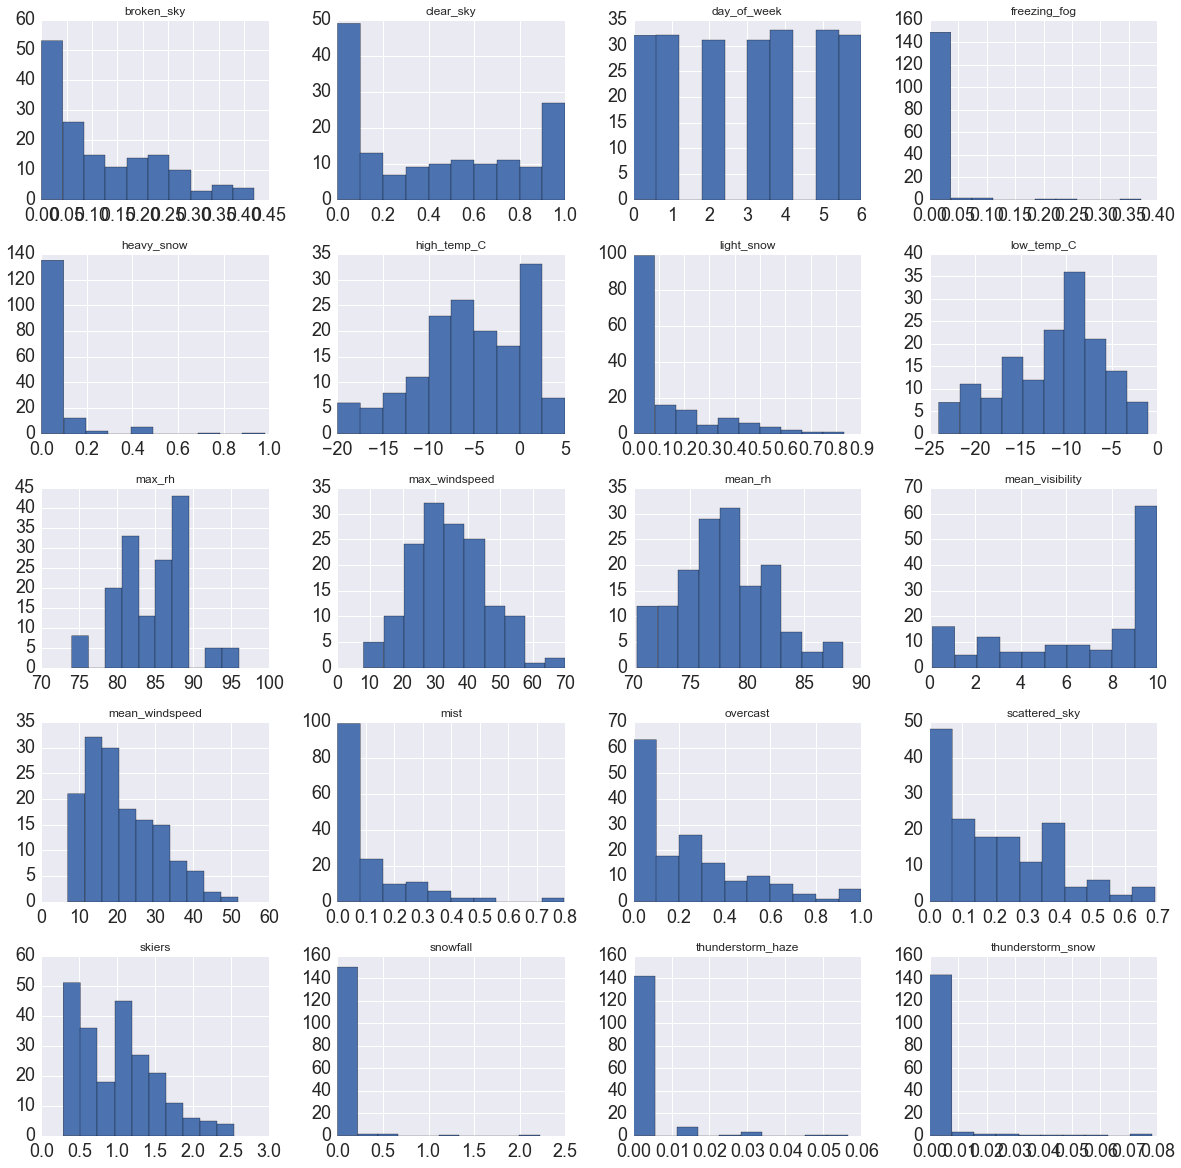

In [349]:
df_all.hist(figsize=(20,20))

### Create a weekend column

In [350]:
df_all['is_weekend'] = df_all.day_of_week.map(lambda day: 1 if day == 5 or day == 6 else 0)

#### Make a Fri/Mon/midweek columns

In [351]:
df_all['is_fri'] = df_all.day_of_week.map(lambda day: 1 if day == 4 else 0)
df_all['is_mon'] = df_all.day_of_week.map(lambda day: 1 if day == 0 else 0)
df_all['is_midweek'] = df_all.day_of_week.map(lambda day: 1 if day == 1 or day == 2 or day == 3 else 0)

#### Drop day of week column

In [352]:
df_all.drop(['day_of_week'], axis=1, inplace=True)

#### Make holiday features

In [353]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holiday_list = calendar.holidays(datetime.datetime(2014, 11, 1), datetime.datetime(2015, 5, 1))

In [354]:
holidays = []
for holiday in holiday_list:
    holidays.append(holiday)

In [355]:
vet_day = holidays[0]
thanksgiv = holidays[1]
xmas = holidays[2]
new_years = holidays[3]
mlk_day = holidays[4]
pres_day = holidays[5]

In [356]:
def make_holiday_column(df, holiday, hol_name):
    is_holiday = []
    for idx, row in df.iterrows():
        diff = abs(idx.date() - holiday.date()).days
        if diff > 7:
            is_holiday.append(0)
        elif diff == 0:
            is_holiday.append(7)
        else:
            is_holiday.append(7-diff)
    df[hol_name] = is_holiday
    return df

In [357]:
df_all = make_holiday_column(df_all, vet_day, 'vet_day')
df_all = make_holiday_column(df_all, thanksgiv, 'thanksgiv')
df_all = make_holiday_column(df_all, xmas, 'xmas')
df_all = make_holiday_column(df_all, new_years, 'new_years')
df_all = make_holiday_column(df_all, mlk_day, 'mlk_day')
df_all = make_holiday_column(df_all, pres_day, 'pres_day')

#### Create (holiday)(weekend) and (holiday)(fri/mon/weekday) features

In [358]:
df_all['xmas_weekend'] = df_all.is_weekend*df_all.xmas
df_all['vet_weekend'] = df_all.is_weekend*df_all.vet_day
df_all['thanksgiv_weekend'] = df_all.is_weekend*df_all.thanksgiv
df_all['new_years_weekend'] = df_all.is_weekend*df_all.new_years
df_all['pres_day_weekend'] = df_all.is_weekend*df_all.pres_day
df_all['mlk_weekend'] = df_all.is_weekend*df_all.mlk_day

In [359]:
df_all['xmas_fri'] = df_all.is_fri*df_all.xmas
df_all['vet_fri'] = df_all.is_fri*df_all.vet_day
df_all['thanksgiv_fri'] = df_all.is_fri*df_all.thanksgiv
df_all['new_years_fri'] = df_all.is_fri*df_all.new_years
df_all['pres_day_fri'] = df_all.is_fri*df_all.pres_day
df_all['mlk_fri'] = df_all.is_fri*df_all.mlk_day

In [360]:
df_all['xmas_mon'] = df_all.is_mon*df_all.xmas
df_all['vet_mon'] = df_all.is_mon*df_all.vet_day
df_all['thanksgiv_mon'] = df_all.is_mon*df_all.thanksgiv
df_all['new_years_mon'] = df_all.is_mon*df_all.new_years
df_all['pres_day_mon'] = df_all.is_mon*df_all.pres_day
df_all['mlk_mon'] = df_all.is_mon*df_all.mlk_day

In [361]:
df_all['xmas_midweek'] = df_all.is_midweek*df_all.xmas
df_all['vet_midweek'] = df_all.is_midweek*df_all.vet_day
df_all['thanksgiv_midweek'] = df_all.is_midweek*df_all.thanksgiv
df_all['new_years_midweek'] = df_all.is_midweek*df_all.new_years
df_all['pres_day_midweek'] = df_all.is_midweek*df_all.pres_day
df_all['mlk_midweek'] = df_all.is_midweek*df_all.mlk_day

### Make spring break column

In [362]:
def make_spring_break_col(df, holiday, hol_name):
    #3/8-3/30 is spring break
    is_holiday = []
    for idx, row in df.iterrows():
        if idx.date() >= datetime.datetime(2015,3,8,0,0,0).date() and idx.date() <= datetime.datetime(2015,3,30,0,0,0).date():
            is_holiday.append(1)
        else:
            is_holiday.append(0)
    df['spring_break'] = is_holiday
    return df

In [363]:
df_all = make_spring_break_col(df_all, holiday, 'hol_name')

In [364]:
def make_spring_trailing_weeks(df, holiday, hol_name):
    #3/8-3/30 is spring break
    is_holiday = []
    for idx, row in df.iterrows():
        if idx.date() >= datetime.datetime(2015,3,1,0,0,0).date() and idx.date() <= datetime.datetime(2015,3,1,0,0,0).date():
            is_holiday.append(1)
        elif idx.date() >= datetime.datetime(2015,3,31,0,0,0).date() and idx.date() <= datetime.datetime(2015,4,5,0,0,0).date():
            is_holiday.append(1)
        else:
            is_holiday.append(0)
    df['spring_break_ends'] = is_holiday
    return df

In [365]:
df_all = make_spring_trailing_weeks(df_all, holiday, 'hol_name')

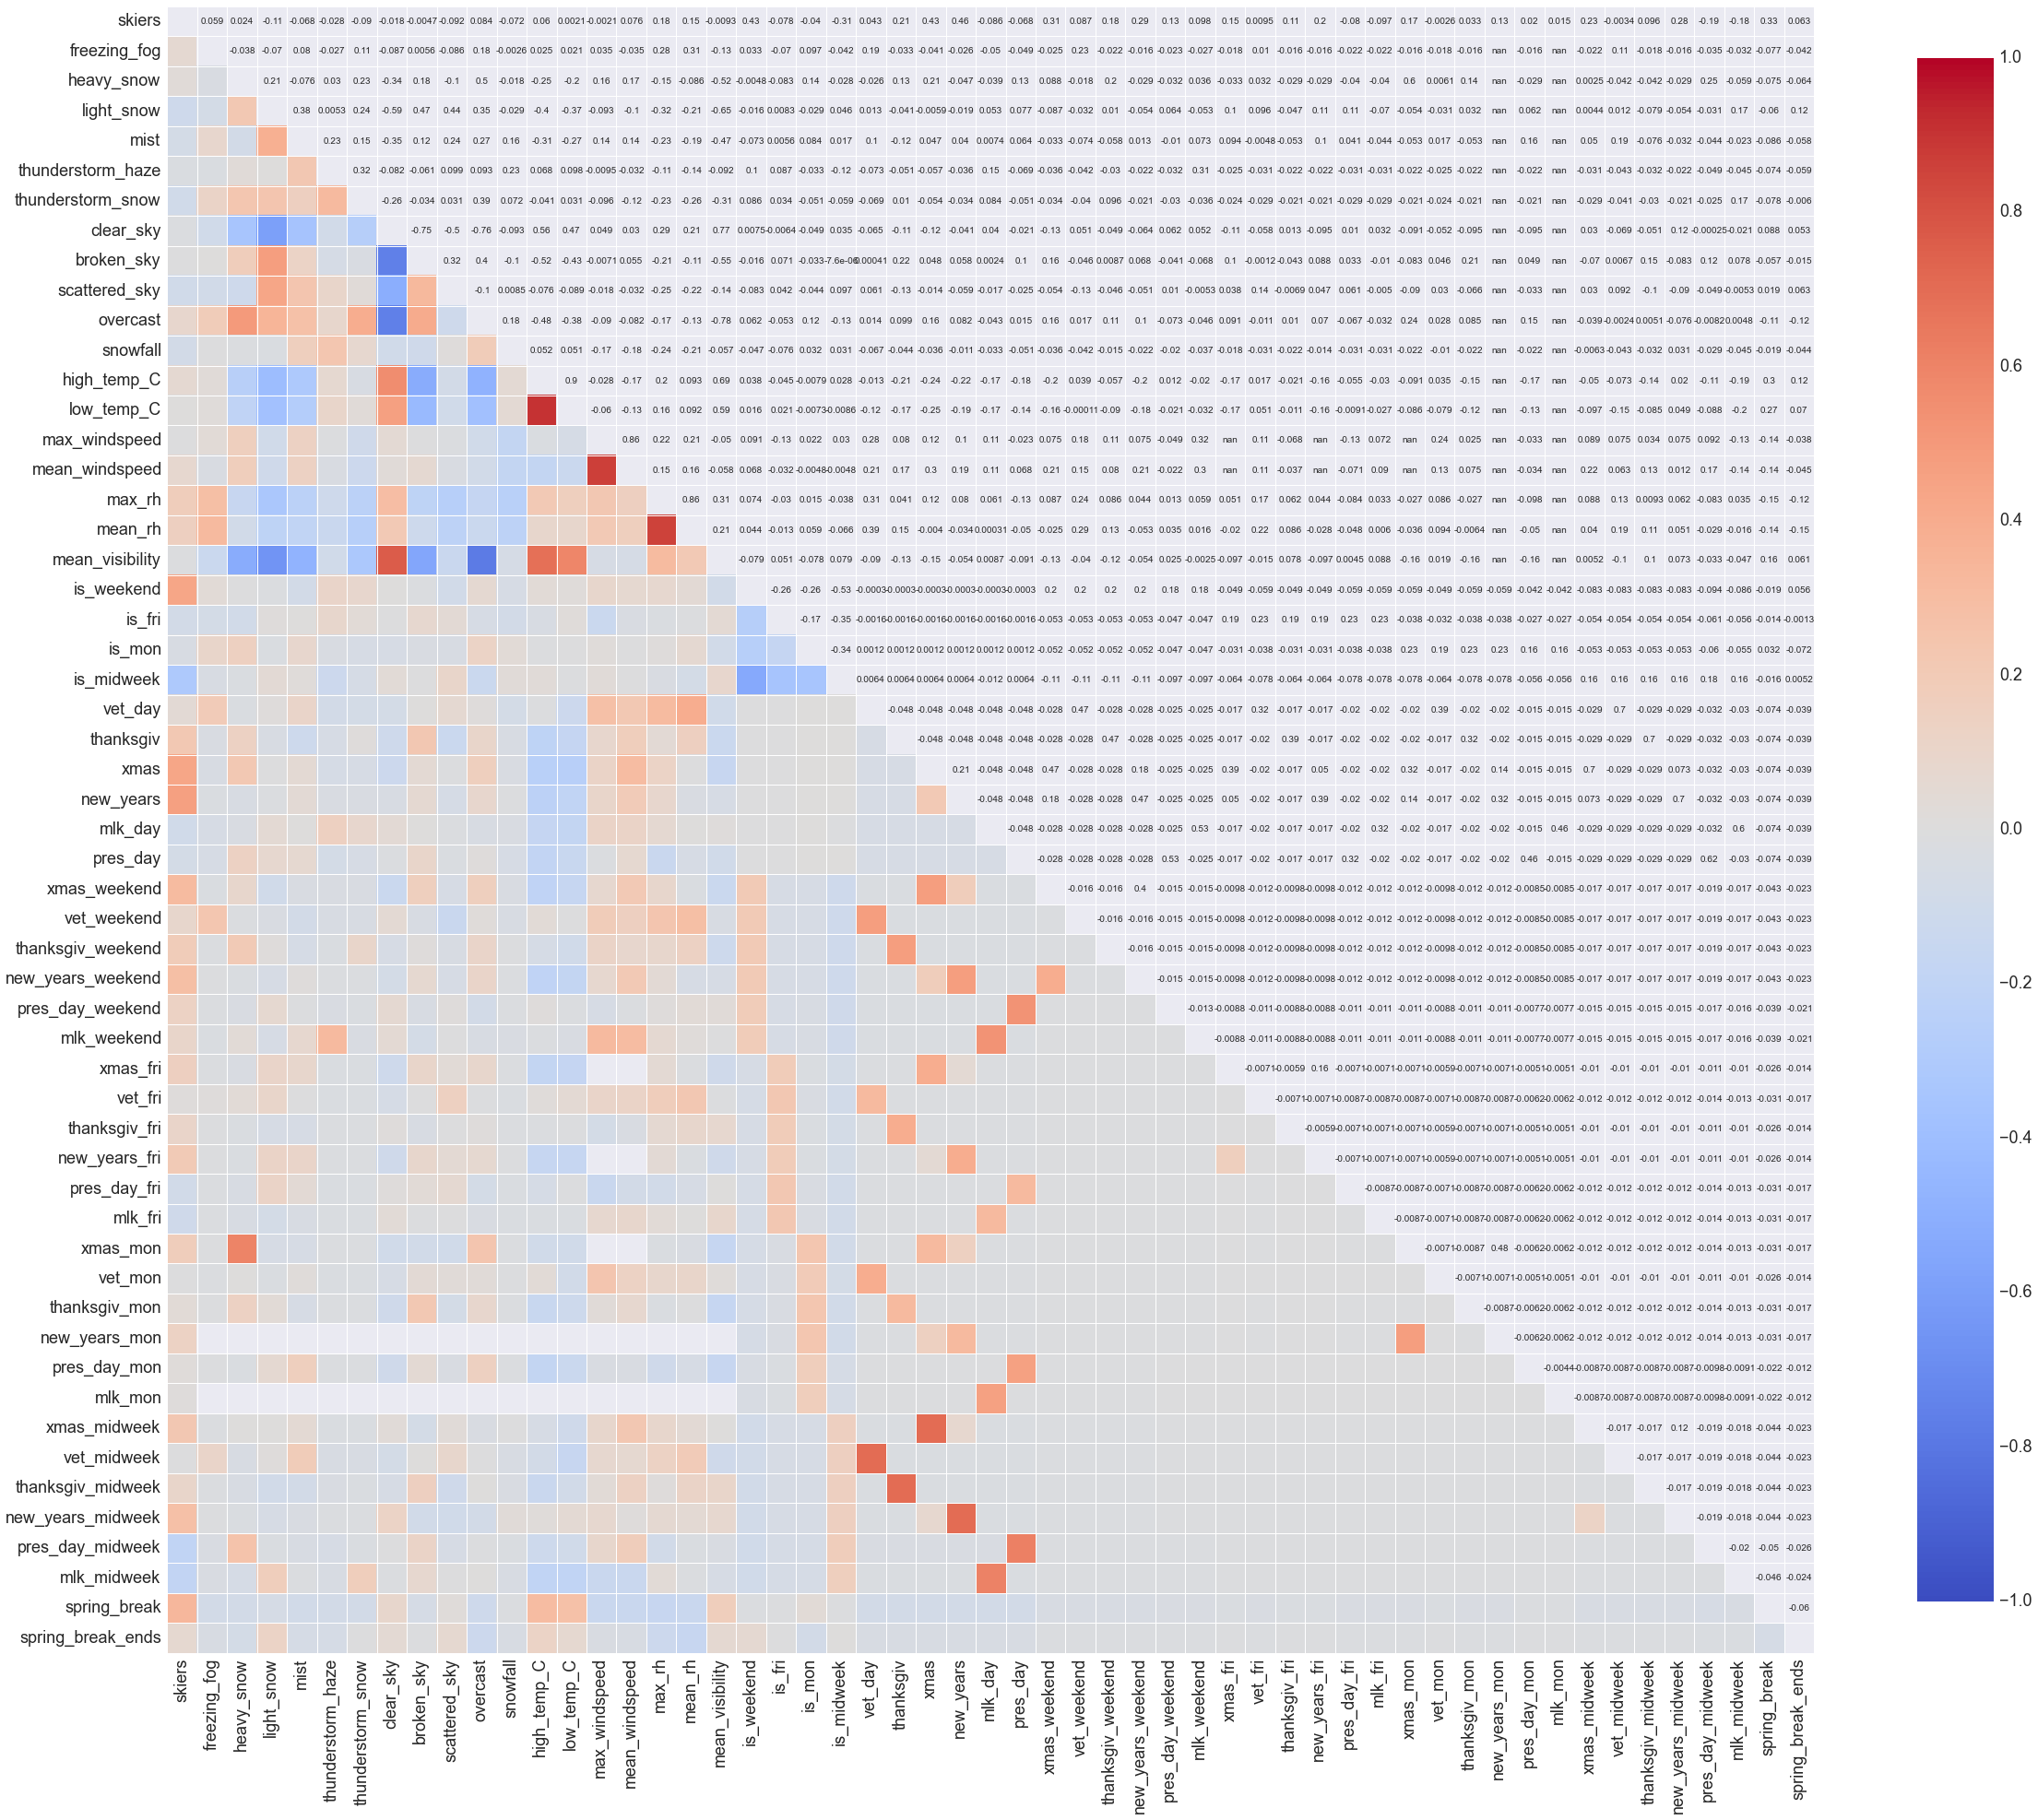

In [366]:
f, ax = plt.subplots(figsize=(40, 40))
sns.corrplot(df_all, annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [368]:
df_all.fillna(df_all.mean(), inplace=True)

,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,...,pres_day_mon,mlk_mon,xmas_midweek,vet_midweek,thanksgiv_midweek,new_years_midweek,pres_day_midweek,mlk_midweek,spring_break,spring_break_ends
2014-10-31,0.971232,0.007779,0.044516,0.116006,0.091954,0.002148,0.003077,0.434859,0.117448,0.198366,...,0,0,0,0,0,0,0,0,0,0
2014-11-01,1.169169,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,...,0,0,0,0,0,0,0,0,0,0
2014-11-02,1.314465,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,...,0,0,0,0,0,0,0,0,0,0
2014-11-03,1.061945,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,...,0,0,0,0,0,0,0,0,0,0
2014-11-04,1.013577,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2014-11-05,0.995124,0.055556,0.000000,0.013889,0.055556,0.000000,0.000000,0.694444,0.041667,0.055556,...,0,0,0,1,0,0,0,0,0,0
2014-11-06,0.994153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0,0,0,2,0,0,0,0,0,0
2014-11-07,1.031448,0.000000,0.000000,0.028169,0.014085,0.000000,0.000000,0.577465,0.084507,0.323944,...,0,0,0,0,0,0,0,0,0,0
2014-11-08,1.305724,0.228571,0.000000,0.000000,0.085714,0.000000,0.000000,0.657143,0.000000,0.042857,...,0,0,0,0,0,0,0,0,0,0
2014-11-09,1.362638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [369]:
lr = linear_model.LinearRegression()

In [370]:
columns = list(df_all.columns.values)
columns.remove('skiers')

In [371]:
X = df_all[columns].values
y = df_all.skiers.values

In [315]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
y = imp.fit_transform(y_nan)
X = imp.fit_transform(X_nan)

In [372]:
y = y.T

In [373]:
mdl = lr.fit(X, y) 

In [374]:
pred = mdl.predict(X)
df_all['model_pred'] = pred

In [375]:
ref_column = 'skiers'

In [376]:
def fitted_vs_ref_plot(df, ref_column):
    plt.figure(facecolor='w', figsize = (8,8))
    a, b, axes, label_size = plot_params()
    plt.plot(df[ref_column], df.model_pred, linestyle = '', marker = '.', alpha = 0.3)
    plt.xlabel('Skier Visits', size = label_size)
    plt.ylabel('Predicted Skier Visits', size = label_size)
    plt.plot([0, df.model_pred.max()], [0,df.model_pred.max()])
    #axes.set_ylim([-20,100])

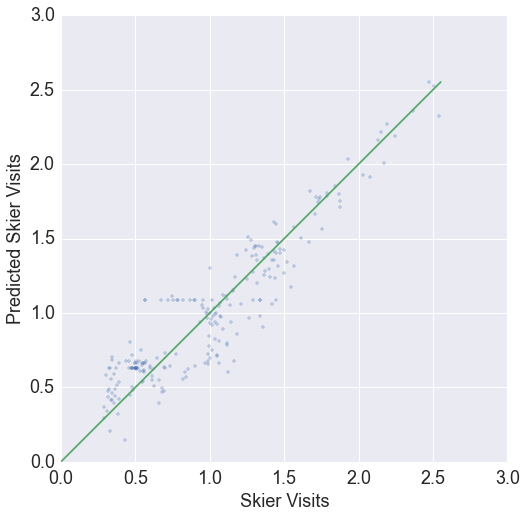

In [377]:
fitted_vs_ref_plot(df_all, ref_column)

In [378]:
def plot_fitted_and_ref_vs_time(df, ref_column):
    plt.figure(facecolor='w', figsize = (15,10))
    a, b, axes, label_size = plot_params()
    df[ref_column].plot(marker = '.',linestyle = '-', label = 'Reference Data')
    df.model_pred.plot(marker = '.',linestyle = '-', label = 'Predicted Data')
    axes.set_ylim([0,3])
    plt.legend(fontsize = label_size)
    plt.ylabel('Ozone Concentration (ppb)', size = label_size)
    plt.xlabel('Date', size = label_size)

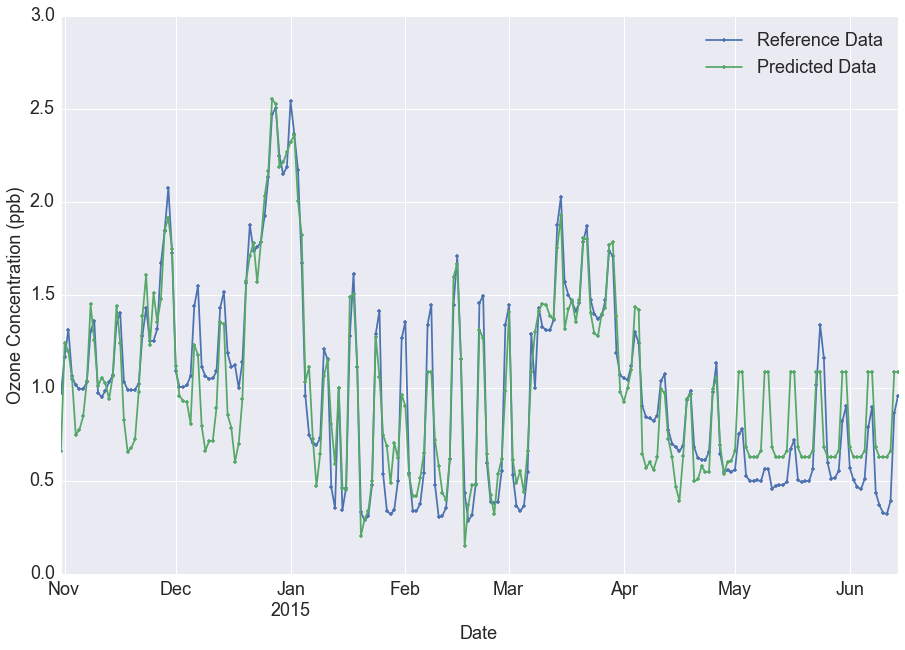

In [379]:
plot_fitted_and_ref_vs_time(df_all, ref_column)

In [380]:
df_all.head()

,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,...,mlk_mon,xmas_midweek,vet_midweek,thanksgiv_midweek,new_years_midweek,pres_day_midweek,mlk_midweek,spring_break,spring_break_ends,model_pred
2014-10-31,0.971232,0.007779,0.044516,0.116006,0.091954,0.002148,0.003077,0.434859,0.117448,0.198366,...,0,0,0,0,0,0,0,0,0,0.662537
2014-11-01,1.169169,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,...,0,0,0,0,0,0,0,0,0,1.241139
2014-11-02,1.314465,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,...,0,0,0,0,0,0,0,0,0,1.199980
2014-11-03,1.061945,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,...,0,0,0,0,0,0,0,0,0,1.049333
2014-11-04,1.013577,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0.748210


# Export Data

In [381]:
df_out = df_all.drop(['model_pred','skiers'], axis=1)

In [404]:
df_out.to_csv('../webpage_ski/df_all_features.csv')

In [383]:
df_out.head()

,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,overcast,...,pres_day_mon,mlk_mon,xmas_midweek,vet_midweek,thanksgiv_midweek,new_years_midweek,pres_day_midweek,mlk_midweek,spring_break,spring_break_ends
2014-10-31,0.007779,0.044516,0.116006,0.091954,0.002148,0.003077,0.434859,0.117448,0.198366,0.236125,...,0,0,0,0,0,0,0,0,0,0
2014-11-01,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,0.000000,...,0,0,0,0,0,0,0,0,0,0
2014-11-02,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,0.115942,...,0,0,0,0,0,0,0,0,0,0
2014-11-03,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,0.725806,...,0,0,0,0,0,0,0,0,0,0
2014-11-04,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,0.291667,...,0,0,0,0,0,0,0,0,0,0


In [285]:
from datetime import datetime


In [286]:
date3 = datetime.strptime('11/1/2014',"%m/%d/%Y")

In [405]:
date3

datetime.datetime(2014, 11, 1, 0, 0)

In [288]:
df_all.index[0]

Timestamp('2014-10-31 00:00:00')

In [385]:
feat = df_all.loc[date3]

In [406]:
date3 - pd.Timedelta(days=1)

datetime.datetime(2014, 10, 31, 0, 0)

In [403]:
dates = [date3]
dates.append(date3 - pd.Timedelta(days=1))

In [388]:
dates

[datetime.datetime(2014, 11, 1, 0, 0), datetime.datetime(2014, 10, 31, 0, 0)]

In [401]:
feat = df_out.loc[dates]

In [402]:
mdl.predict(feat)

array([ 1.24113897,  0.66253667])

In [308]:
len(X[:,1:])

2

In [ ]:
feat.head()

In [ ]:
float(intercept)

In [ ]:
crowd

In [ ]:
type(mdl)

In [ ]:
import cPickle as pickle

In [393]:
pickle_out = open('lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

In [ ]:
def load_classifier(fname):
   # load it again
   with open(fname, 'rb') as fid:
       clf = pickle.load(fid)    
       #clf = joblib.load(fname)

   return clf

In [ ]:
aa = load_classifier('lin_regr.pkl')

In [ ]:
aa

In [ ]:
crowd = aa.predict(feat[1:])

In [ ]:
def plot_params():
    size = 40
    a = plt.rc('xtick', labelsize = size)
    b = plt.rc('ytick', labelsize = size)
    return a, b, size

In [ ]:
def make_bar_chart(crowd, y_label, dates):
    a, b, label_size = plot_params()
    N = len(crowd)


    ind = np.arange(N)  # the x locations for the groups
    width = 0.35      # the width of the bars

    fig, ax = plt.subplots(figsize=(20, 10), facecolor='white', frameon=False)
    #plt.box(on='off')
    rects1 = ax.bar(ind, crowd, width, color='#bdbdbd', edgecolor = "none")

    # add some text for labels, title and axes ticks
    ax.set_ylabel(y_label, size = label_size)
    ax.set_title(' ')
    ax.set_xticks(ind + width)
    #tick_labels = dates.tolist()
    #ax.set_xticklabels(tick_labels)
    ax.grid(False)
    #plt.ylim([0,18])
    #make the border lines lighter
    [i.set_linewidth(0.1) for i in ax.spines.itervalues()]

    #remove the y axis
    #frame1 = plt.gca()
    #frame1.axes.get_yaxis().set_visible(False)

    #draw legend
    #ax.legend( (rects1[0], rects2[0]), ('Base Features', 'Best Features') , loc = 'best', fontsize = label_size, frameon=False)

    return fig